In [2]:
import json
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn

import model_utils
import plot_utils
import custom_transforms
from dataset import COCO_Person_Dataset
from nn_model import Net
from CONSTANTS import idx_to_keypoint_type
from custom_transforms import *
import torch.nn.functional as F
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
import time

In [2]:
#17 keypoints
#'nose', 'left_eye', 'right_eye', 'left_ear', 'right_ear', 'left_shoulder', 'right_shoulder', 
#'left_elbow', 'right_elbow', 'left_wrist', 'right_wrist', 'left_hip', 'right_hip', 'left_knee', 
#'right_knee', 'left_ankle', 'right_ankle'

In [3]:
processed_files = {
    'img_id_to_annotations': 'img_id_to_annotations.npy',
    'img_id_to_image_info' : 'img_id_to_image_info.npy',
    'im_ids' : 'im_ids.npy'
}

In [4]:
mean, std = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]
mean, std = torch.tensor(mean), torch.tensor(std)

tfms = transforms.Compose([
    ResizeImgAndKeypoints(368),
    #ColorJitter(),
    RandomGrayscale(),
    #RandomFlipImgAndKeypoints(),
    #RandomRotateImgAndKeypoints()
])

tensor_tfms = transforms.Compose([
    ToTensor(),
    NormalizeImg(mean, std)
])

un = UnNormalizeImgBatch(mean, std)
p = transforms.ToPILImage()

In [5]:
bs = 8
ds = COCO_Person_Dataset('train2014/', processed_files, tfms, tensor_tfms)
dl = torch.utils.data.DataLoader(ds, bs, shuffle=True)

In [6]:
%%time 
for x,y,z,a,b in dl:
    break   

'get_paf_masks'  154.40 ms
'get_paf_masks'  126.46 ms
'get_paf_masks'  53.41 ms
'get_paf_masks'  191.06 ms
'get_paf_masks'  56.70 ms
'get_paf_masks'  119.20 ms
'get_paf_masks'  164.78 ms
'get_paf_masks'  206.06 ms
CPU times: user 8.04 s, sys: 227 ms, total: 8.26 s
Wall time: 1.4 s


In [7]:
#model.freeze_F()
#model.train_paf_stage(2)
#model.freeze_all_paf_stages()
#model.train_hm_stage(2)
#model.set_to_inference()

In [6]:
model = Net(in_training=True)
model.load_state_dict(torch.load('hm-stage2-bg-training-model.ckpt', map_location='cpu'))
#model.freeze_F()
#model.freeze_all_paf_stages()
#model.train_hm_stage(1)
model.set_to_inference()
model.to(device)

Net(
  (F): F(
    (vgg): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace)
      (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1)

In [7]:
model.F.conv_4_3_and_4_4 = nn.Sequential(
                                              nn.Conv2d(512, 256, 3, 1, 1),
                                              nn.BatchNorm2d(256),
                                              nn.ReLU(inplace=True),
                                              nn.Conv2d(256, 125, 3, 1, 1),
                                              nn.BatchNorm2d(125),
                                              nn.ReLU(inplace=True)
                                              )

In [8]:
im, im46x46,_,_,_,_ = ds[0]

In [ ]:
model.train()
n_epochs = 1
lr = 0.0001
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr = lr)

total_steps = 0
prev_avg = -1
loss_running_avg_250_iter = 0

for e in range(n_epochs):
    for imgs, pafs, paf_inds, hms, hm_inds in dl:
        optimizer.zero_grad()
        
        imgs, pafs, paf_inds, hms, hm_inds = imgs.to(device), pafs.to(device), paf_inds.to(device), hms.to(device), hm_inds.to(device) 
        pred_pafs, pred_hms = model(imgs)
        loss = model_utils.paf_and_heatmap_loss(pred_pafs, pafs, paf_inds, pred_hms, hms, hm_inds)
        
        loss.backward()
        optimizer.step()
        
        total_steps +=1
        loss_running_avg_250_iter += loss.item()
        if(total_steps%250==0):
            torch.save(model.state_dict(),'paf-stage4-training-model.ckpt')
            print('saving model')
            if(prev_avg==-1):
                prev_avg = loss_running_avg_250_iter/250
            elif(np.abs(prev_avg - (loss_running_avg_250_iter/250))<=2 or loss_running_avg_250_iter/250 > prev_avg+5):
                lr = lr/10
                optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr = lr)
                print('changing LR', lr, np.abs(prev_avg - (loss_running_avg_250_iter/250)))
                prev_avg = loss_running_avg_250_iter/250
            print('current running avg loss:', loss_running_avg_250_iter/250)
            loss_running_avg_250_iter = 0
                                                       
        model_utils.print_training_loss_summary(loss.item(), total_steps, e+1, n_epochs, len(dl))

In [ ]:
#torch.save(model.state_dict(),'stage1-trained.ckpt')

In [ ]:
%%time
with torch.no_grad():
    model.eval()
    imgs, _, _, _, _ = iter(dl).next()
    pred_pafs_stages, pred_hms_stages = model(imgs.to(device))
    scaled_pafs = F.interpolate(pred_pafs_stages, 368, mode="bilinear", align_corners=True).to(device)
    scaled_hms = F.interpolate(pred_hms_stages, 368, mode="bilinear", align_corners=True).to(device)

In [12]:
model.Heatmap_Stages.in_training

False

In [8]:
#pf[torch.abs(pf)<1e-1].sum()

tensor(134.2673)

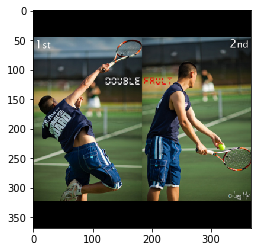

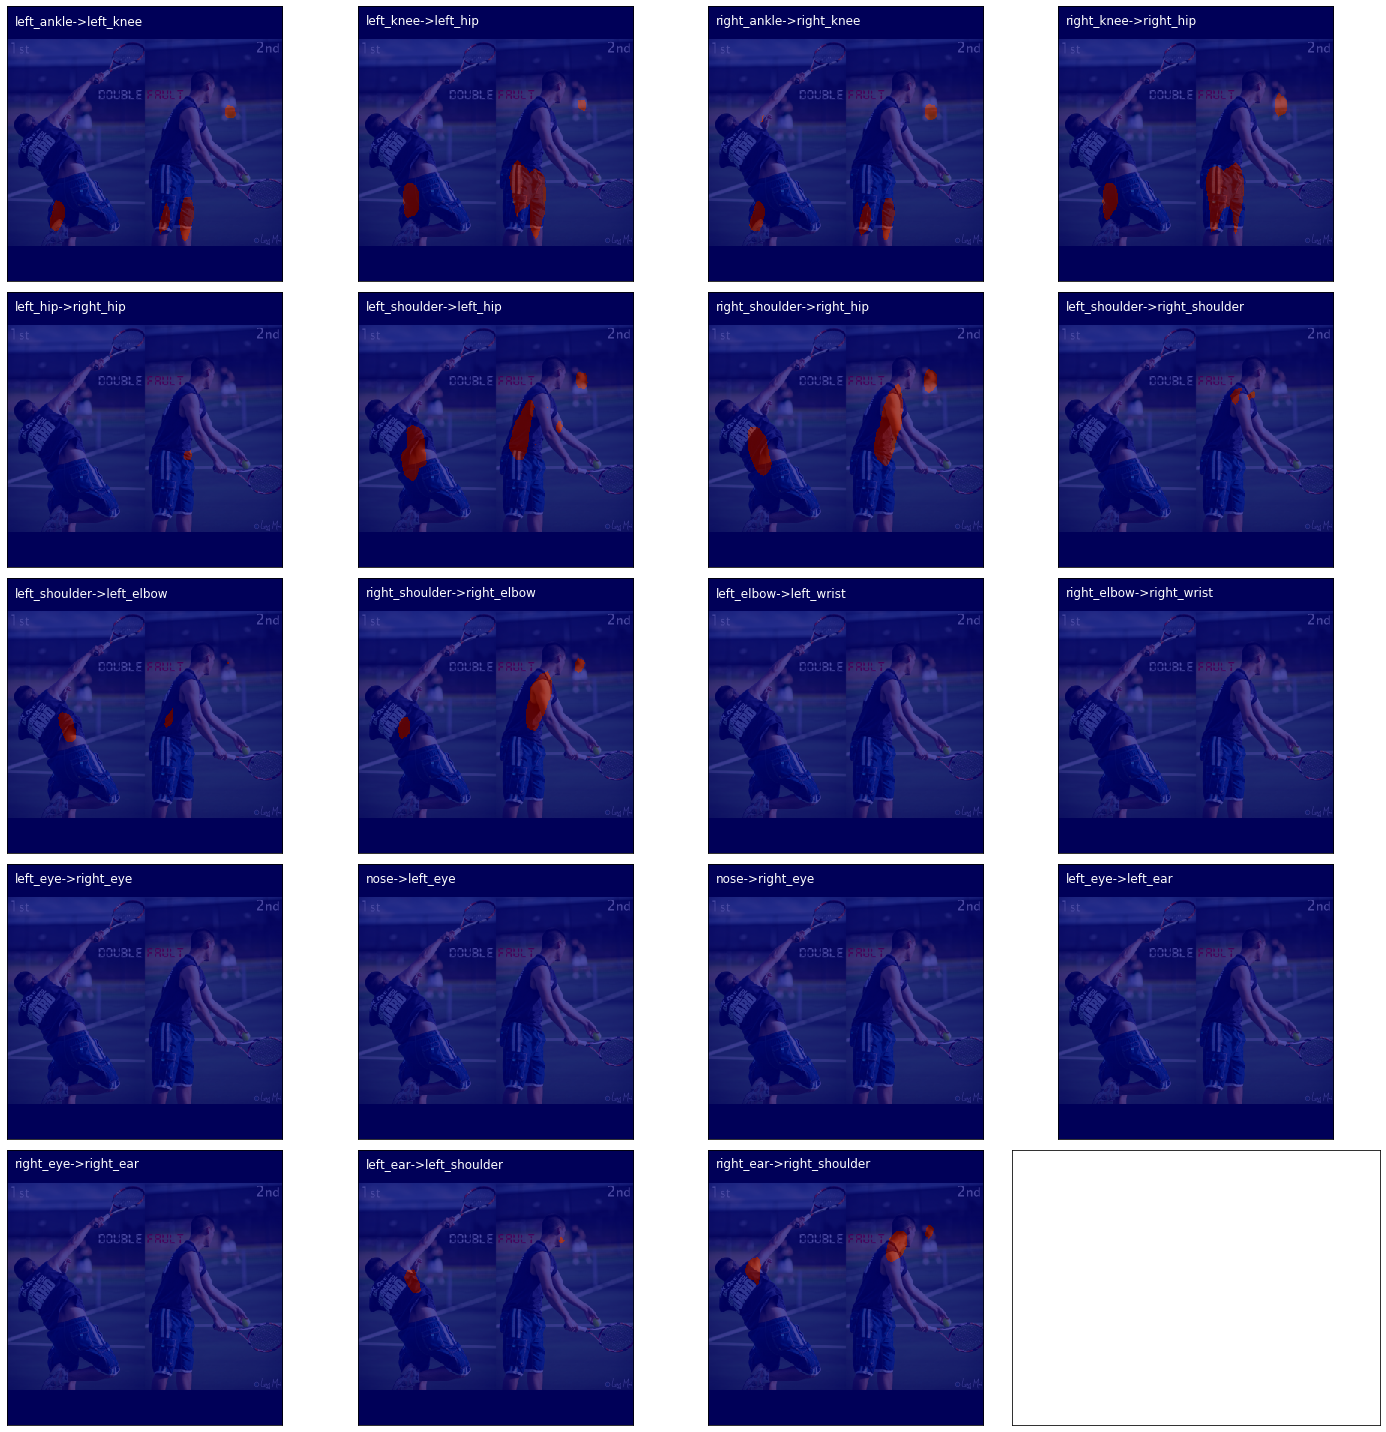

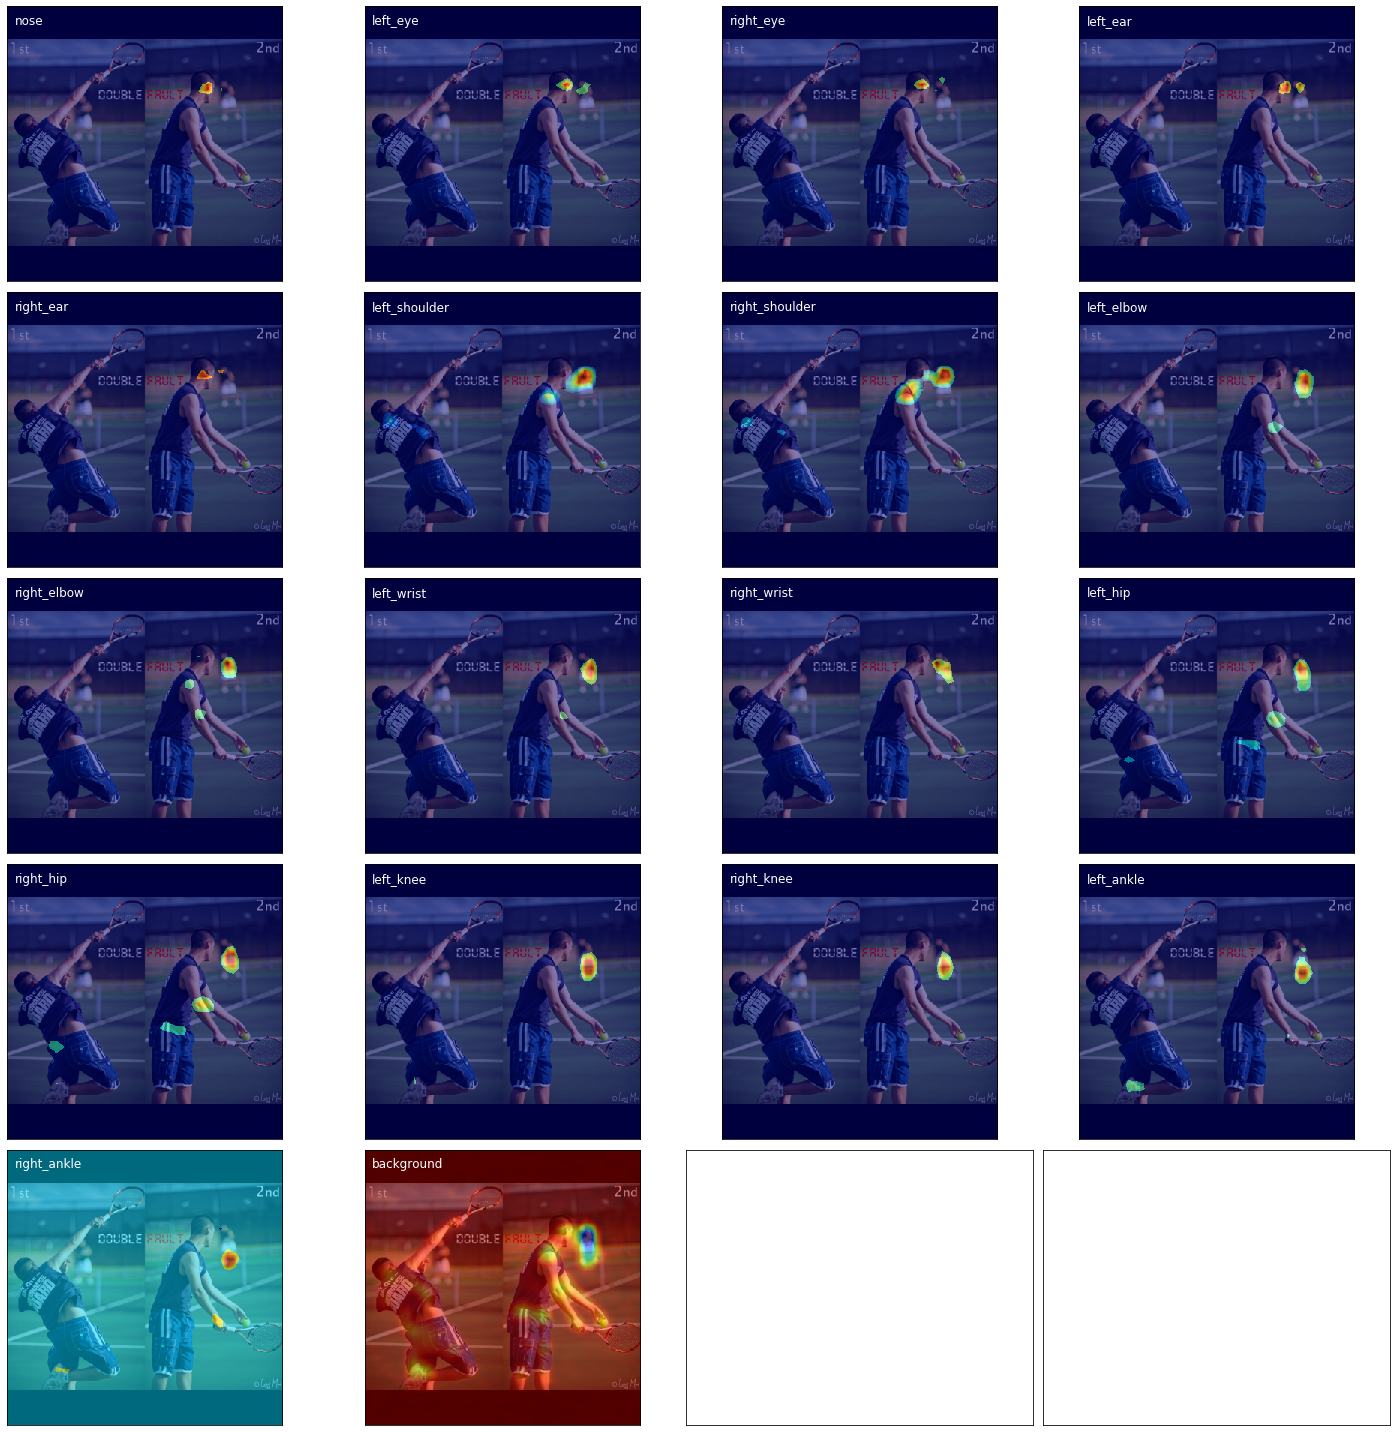

In [12]:
idx = 5
im = imgs[idx]
pf = scaled_pafs[idx].clone()
hm = scaled_hms[idx].clone()
pf[torch.abs(pf)<1e-1] = 0
hm[torch.abs(hm)<5e-2] = 0

un_im = p(un(im)[0])
plt.imshow(un_im)
plot_utils.plot_pafs(un_im, pf.numpy(), figsize=(20,20))
plot_utils.plot_heatmaps(un_im, hm.numpy(), figsize=(20,20))

In [12]:
%%time
i,pafs,paf_ind,hms,hms_ind = ds[0]

'get_paf_masks'  103.12 ms
CPU times: user 645 ms, sys: 7.02 ms, total: 652 ms
Wall time: 122 ms


In [ ]:
def get_paf_masks_vectorized(img, keypoints, part_pairs=SKELETON, limb_width=5):
    img = np.array(img)
    h,w = img.shape[:2]
    pafs = np.zeros((len(part_pairs)*2, h, w))
    PAF_BINARY_IND = np.zeros(len(part_pairs)*2)
    fliped_img = img.transpose((1,0,2))
    
    for i, joint_pair in enumerate(part_pairs):
        mask, PAF_IS_LABELED = calculate_paf_mask(fliped_img, joint_pair, keypoints, limb_width)
        PAF_BINARY_IND[2*i], PAF_BINARY_IND[(2*i)+1]  = int(PAF_IS_LABELED), int(PAF_IS_LABELED)
        mask = mask.transpose((0,2,1))
        pafs[2*i], pafs[(2*i) +1] = mask[0], mask[1]   #x component, y component of v
    return pafs, PAF_BINARY_IND


In [ ]:
@timeit
def get_paf_masks_vectorized(img, keypoints, joint_pairs=BODY_PARTS, limb_width=5):
    img = np.array(img)
    h,w = img.shape[:2]
    
    PAF_BINARY_IND = np.zeros((len(BODY_PARTS), 2))
    out_pafs = np.zeros((len(BODY_PARTS), 2, h, w))
    n_person_part = np.zeros((len(BODY_PARTS), h, w))
    
    for person_id in range(keypoints.shape[0]):
        keypoints_person = keypoints[person_id]
        for i in range(len(BODY_PARTS)):
            part = BODY_PARTS[i]
            keypoint_1 = keypoints_person[part[0], :2]
            keypoint_2 = keypoints_person[part[1], :2]

            if(keypoints_person[part[0], 2] > 0 and keypoints_person[part[1], 2] > 0):
                PAF_BINARY_IND[i,0], PAF_BINARY_IND[i,1] = 1, 1
                part_line_segment = keypoint_2 - keypoint_1
                l = np.linalg.norm(part_line_segment)
                if l>1e-2:
                    
                    v = part_line_segment/l
                    v_per = v[1], -v[0]
                    x, y = np.meshgrid(np.arange(w), np.arange(h))
                    dist_along_part = v[0]* (x - keypoint_1[0]) + v[1] * (y - keypoint_1[1])
                    dist_per_part = np.abs(v_per[0] * (x - keypoint_1[0]) + v_per[1] * (y - keypoint_1[1]))
                    mask1 = dist_along_part>=0
                    mask2 = dist_along_part<=l
                    mask3 = dist_per_part <=limb_width
                    mask = mask1 & mask2 & mask3
                    out_pafs[i,0] = out_pafs[i,0] + mask.astype('float32') * v[0]
                    out_pafs[i,1] = out_pafs[i,1] + mask.astype('float32') * v[1]
                    n_person_part += mask.astype('float32')
    n_person_part = n_person_part.reshape(out_pafs.shape[0], 1, h, w)
    out_pafs = out_pafs/(n_person_part + 1e-8)
    return out_pafs, PAF_BINARY_IND


In [ ]:
h,w = np.array(im).shape[:2]
limb_width = 5
j1 = 15
j2 = 13
kps_j1 = kp[:,j1, :]
kps_j2 = kp[:,j2, :]
both_exist = np.logical_and(kps_j1[:,2], kps_j2[:,2])
V = kps_j2[both_exist, :2] - kps_j1[both_exist, :2]
norm = np.linalg.norm(V,axis=1,keepdims=True)
valid_v = norm.ravel()>1e-2
V[np.logical_not(valid_v)] = np.array([0,0])
V = V/norm
V_Perp = V.copy()
V_Perp[:,[0,1]] = V_Perp[:,[1,0]]
V_Perp[:,1] = -V_Perp[:,1] 

Z, X, Y = np.meshgrid(np.arange(w), np.arange(h), np.arange(2))
dist_along_part = V[:,0]* (X - kps_j1[:,0]) + V[:,1] * (Y - kps_j1[:,1])
print(dist_along_part.shape)
#dist_per_part = np.abs(V_Perp[:,0] * (X -kps_j1[:,0]) + V_Perp[:,1] * (Y - kps_j1[:,1]))
mask1 = dist_along_part>=0
#mask2 = dist_along_part<=norm.ravel()
#mask3 = dist_per_part <=limb_width
#mask = mask1 & mask2 & mask3
#mask = np.amax(mask, axis=2)


'get_paf_masks'  93.04 ms


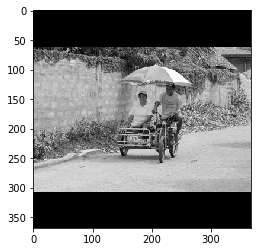

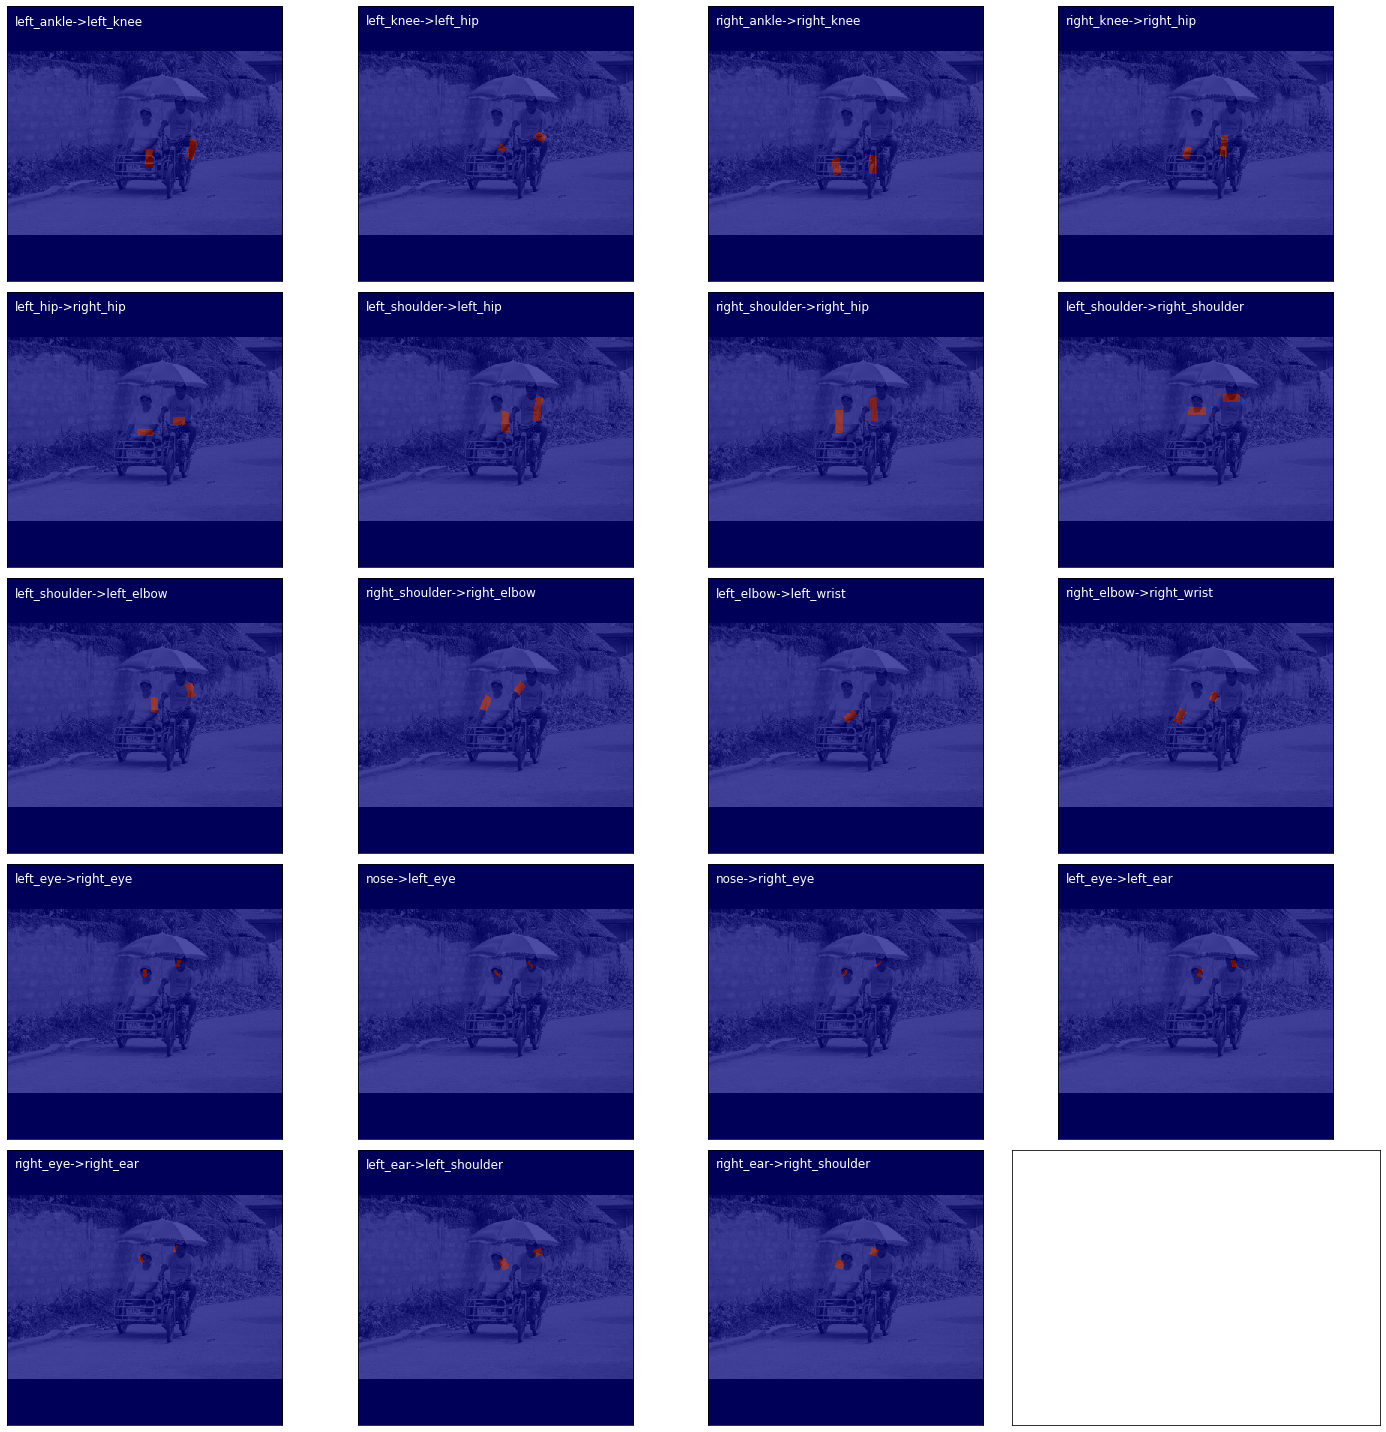

In [9]:
i,pafs,paf_ind,hms,hms_ind = ds[0]
un_im = p(un(i)[0])
plt.imshow(un_im)
plot_utils.plot_pafs(un_im, pafs.numpy(), figsize=(20,20))
#plot_utils.plot_heatmaps(un_im, hms.numpy(), figsize=(20,20))